Original location of this notebook: CSA GitLab repo `3d1d-advection-paper:notebooks/Results_Mppnp`

In [1]:
%matplotlib inline
# %pylab ipympl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib as mpl
import scipy.integrate
import sys
import os
import time
import logging
import collections
import pickle

# spherical harmonics tools
import pyshtools.expand 
import pyshtools.spectralanalysis

# my modules
# pwd = os. getcwd()
# nugridpy_git = "9414d08" # make pre-processing files and marker options for multiple abu_profile plot
# nugridpy_dir = '/user/scratch14_csa/dstephens/NuGridPy'
# os.chdir(nugridpy_dir)
# git_hash = os.popen('git rev-parse --short HEAD').read().rstrip()
# if not git_hash == nugridpy_git: 
#     print("WARNING: NuGridPy should be on "+nugridpy_git+" but is on "+git_hash)
# sys.path.insert(0,nugridpy_dir)  
import nugridpy.ascii_table as table
from nugridpy import nugridse as nuse
import nugridpy.utils as utils
import nugridpy.astronomy as ast

from astropy import constants as const
from astropy import units as u

Msun = (const.M_sun.to(u.g)).value
Rsun = (const.R_sun.to(u.cm)).value

# pyppm_git = '582dd18'
# pyppm_dir = '/user/scratch14_csa/dstephens/PyPPM/'
# os.chdir(pyppm_dir)
# git_hash = os.popen('git rev-parse --short HEAD').read().rstrip()
# if not git_hash == pyppm_git: 
#     print("WARNING: PyPPM should be on "+pyppm_git+" but is on "+git_hash)
pyppm_dir = '/user/niagara_scratch_fherwig/repos/PyPPM/'
sys.path.insert(0,pyppm_dir)  
from ppmpy import ppm

##########################################################################
# os.chdir(pwd)
cb = utils.linestylecb # colours

# plot things
ifig = 0
ptrack = {}

# figure sizes
stdSize = 4.
stdRatio = 4./3.

# turn off matplotlib messages
logging.getLogger("matplotlib").setLevel(logging.ERROR)

In [2]:
# to easily compare between the two models, a master dictionary is used
run_dependent_quantities = ['moms', 'rprof', 'dump0', 'time0', 'dumpMax', 'dumps', 'times', 'initbase', 
                            'simDump0', 'simTime0', 'simDumpMax', 'mbot', 'mtop', 'DFVvr_c12pg', 
                            'Dvr_c12pg', 'up_c12pg', 'down_c12pg', 'DFVvr_fnet', 'Dvr_fnet', 'up_fnet',
                            'down_fnet', 'nrepeatDump0', 'nsubt']
runs = ['n16', 'n17']

# to get "run_dependent_quantities", use a named tuple
allruns = collections.namedtuple('allruns', run_dependent_quantities)

# temporary fill values for anything past rprof
tempfill = [40] * (len(run_dependent_quantities)-2)

Although the paper may change since the origin of this notebook, the figures and what they are conveying should not change significantly. The plots are done in sections like that.

collect all of the quantities for each named tuple and create the master dictionary

In [3]:
# N16
moms_dir = '/data/ASDR/PPMstar/LowZRAWD/N16-LowZRAWD-1536-10x-burn-moms/myavsbq'
rprof_dir = '/data/ASDR/PPMstar/LowZRAWD/N16-LowZRAWD-1536-10x-burn-moms/prfs/'

var_list = ['xc','ux','uy','uz','|ut|','|ur|','|w|','P','rho','fv']
n16 = allruns(ppm.MomsDataSet(moms_dir,400,2,var_list,rprofset=ppm.RprofSet(rprof_dir)),
              ppm.RprofSet(rprof_dir),*tempfill)

# N17
moms_dir = '/data/ASDR/PPMstar/LowZRAWD/N17-LowZRAWD-1152-100x-burn-moms/myavsbq'
rprof_dir = '/data/ASDR/PPMstar/LowZRAWD/N17-LowZRAWD-1152-100x-burn-moms/prfs/'

var_list = ['xc','ux','uy','uz','|ut|','|ur|','|w|','P','rho','fv']
n17 = allruns(ppm.MomsDataSet(moms_dir,400,2,var_list,rprofset=ppm.RprofSet(rprof_dir)),
              ppm.RprofSet(rprof_dir),*tempfill)

1618 rprof files found in '/data/ASDR/PPMstar/LowZRAWD/N16-LowZRAWD-1536-10x-burn-moms/prfs/.
Dump numbers range from 0 to 1617.
1616 .aaa files found in '/data/ASDR/PPMstar/LowZRAWD/N16-LowZRAWD-1536-10x-burn-moms/myavsbq/.
Dump numbers range from 0 to 1615.
1618 rprof files found in '/data/ASDR/PPMstar/LowZRAWD/N16-LowZRAWD-1536-10x-burn-moms/prfs/.
Dump numbers range from 0 to 1617.
1373 rprof files found in '/data/ASDR/PPMstar/LowZRAWD/N17-LowZRAWD-1152-100x-burn-moms/prfs/.
Dump numbers range from 0 to 1372.
1371 .aaa files found in '/data/ASDR/PPMstar/LowZRAWD/N17-LowZRAWD-1152-100x-burn-moms/myavsbq/.
Dump numbers range from 0 to 1370.
1373 rprof files found in '/data/ASDR/PPMstar/LowZRAWD/N17-LowZRAWD-1152-100x-burn-moms/prfs/.
Dump numbers range from 0 to 1372.


Convenience functions used throughout

In [4]:
# convert a mass coordinate to radius
def m2r(masscoord, myrun, dump):
    # stop printing, too much
    devnull = open(os.devnull, 'w')
    with RedirectStdStreams(stdout=devnull, stderr=devnull):
        m = myrun.rprof.compute_m(dump)
        r = myrun.rprof.get('R',fname=dump,resolution='l')
    return ppm.interpolate(m,r,masscoord)

def readSCFile(initbase, fileExt, dump):
    """
    Read in a .shell or .central file at dump
    Returns the data and header dictionaries
    """

    # counters
    headerLines = 0
    dataLines = 0

    # lists to hold results
    data_keys =[]
    header = {}

    # open the file
    openfile = initbase + '-{0:04d}.{1:s}'.format(dump, fileExt)

    with open(openfile) as myfile:

        # get all lines
        lines = [line.rstrip() for line in myfile]

        # run through the lines
        for line in lines:

            # grab the data keys
            if line.startswith('#'):
                data_keys.extend(line.split(' ')[1:])
                headerLines += 1

            # Grab the header data
            elif line.find('=') != -1:

                # split across = sign, remove whitespace
                split = line.split('=')

                # Now I need to know what type the header should be!
                if split[1].strip().isdecimal():
                    hval = int(split[1].strip())
                elif split[1].strip().find('.') != -1:
                    hval = float(split[1].strip())
                else:
                    hval = split[1].strip()

                # put into dictionary
                header[split[0].strip()] = hval
                headerLines += 1

            # we are now reading in data, this is after all header data
            else:

                # if we are at the first line, create arrays and dict
                if dataLines == 0:
                    data = collections.OrderedDict(zip(data_keys,
                                    map(np.zeros, [len(lines) - headerLines] * len(data_keys))))

                # split the line into its numbers
                line = " ".join(line.split())
                split = line.split(' ')

                for i, key in enumerate(data.keys()):
                    data[key][dataLines] = float(split[i])

                # update line number
                dataLines += 1
                
    return data, header

# use remove print to console at certain points then return
class RedirectStdStreams(object):
    def __init__(self, stdout=None, stderr=None):
        self._stdout = stdout or sys.stdout
        self._stderr = stderr or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr

mppnp se file convenience functions

In [5]:
def get_nsubt(initbase, simDump0, simDumpMax):
    
    # return an array with the nsubt timesteps taken at every dump within the simulation time
    
    # what dumps are we going to read in
    dumps = list(range(simDump0, simDumpMax))
    nsubt = np.zeros(len(dumps), dtype=np.int16)
    
    for i,dump in enumerate(dumps):

        # read in file
        data, headers = readSCFile(initbase,'shell', dump)
        nsubt[i] = int(headers['subtimesteps'])
        
    return nsubt

def removelists(se, get_quantity, cycle):
    
    # with all mppnp runs there is a possibility of getting a list of results. Take the last one
    got_quantity = se.get(int(cycle), get_quantity)
    
    # I have ~250 zones in all, if its len is small, it is a list
    if len(got_quantity) < 100:
        got_quantity = got_quantity[-1]
    
    return got_quantity

# get the correpsonding cycle from a ppmstar dump
def dump2cycle(nrepeat, nsubt, dump, simDump0):
    if dump == simDump0:
        return int(nrepeat)
    else:
        return int(nrepeat + nsubt[0:(dump-simDump0)].sum())
    
# Transform a shell quantity to a central quantity
def shell2central(shell_quantity):
    return ((np.roll(shell_quantity, -1) + shell_quantity) / 2.)[0:-1]

Burning calculations

In [6]:
def vc12pg(T9, rho):
    """
    Reaction rate of C12(p, gamma)N13
    """

    # a ton of coefficients
    TP13 = T9**(1./3.)
    TP23 = TP13*TP13
    TP12 = np.sqrt(T9)
    TP14 = np.sqrt(TP12)
    TP32 = T9*TP12
    TM13 = 1./TP13
    TM23 = 1./TP23
    TM32 = 1./TP32

    T9inv = 1. / T9
    thyng = 2.173913043478260869565 * T9
    vc12pg = 20000000.*TM23 * np.exp(-13.692*TM13 - thyng*thyng)
    vc12pg = vc12pg * (1. + T9*(9.89-T9*(59.8 - 266.*T9)))
    thing2 = vc12pg + TM23 * 1.0e5 * np.exp(-4.913*T9inv) + \
                      TM32 * 4.24e5 * np.exp(-21.62*T9inv)

    thing2[np.where(T9 < .0059)] = 0.
    thing2[np.where(T9 > 0.75)] = 200.

    # multiply the reaction rate by 1000 because density is 1000 g / cm^3
    vc12pg = thing2 * rho * 1000.

    return vc12pg

def drhoH_dt(XH, XC12, rho, T9, dV):
    
    # constants
    AH = 1.
    AC12 = 12.

    # rho is in PPMStar units
    dm = rho * dV
    
    # get dYHdt and convert to drhodt
    dYHdt = (XH / AH) * (XC12 / AC12) * vc12pg(T9, rho)
    drhoHdt = dYHdt * AH * dm / dV
    
    return drhoHdt

Run and other Constants

In [7]:
atomicnoH = 1.
atomicnoC12 = 12.
atomicnocld = n16.rprof.get('atomicnocld',fname=0)
atomicnoair = n16.rprof.get('atomicnoair',fname=0)
fkcld = n16.rprof.get('fkcld',fname=0)
fkair = n16.rprof.get('fkair',fname=0)
cldmu = n16.rprof.get('cldmu',fname=0)
airmu = n16.rprof.get('airmu',fname=0)

Everything should be done at a single dump

In [8]:
# based off of N16
n16_dump0 = 650
n16_time0 = n16.rprof.get('t',n16_dump0)

# i will construct the time arrays, history is wrong!
n17_dumps = np.array(n17.rprof.get_dump_list())
n16_dumps = np.array(n16.rprof.get_dump_list())
n17_times = np.zeros(len(n17_dumps))
n16_times = np.zeros(len(n16_dumps))

for i,dump in enumerate(n17_dumps):
    n17_times[i] = n17.rprof.get('t',dump)
    
for i,dump in enumerate(n16_dumps):
    n16_times[i] = n16.rprof.get('t',dump)
    
# now find what the appropriate times are
dumpi = np.argmin(abs(n16_time0 - n17_times))
n17_dump0 = n16_dumps[dumpi]
n17_time0 = n17_times[dumpi]

Seeing that the runs have been done for longer, there are some forced dumpMax

In [9]:
n16_dumpMax = n16_dumps[-1]
n17_dumpMax = n17_dumps[-1]

Find the dump0 and time0 for the python simulation runs for post-processing

In [10]:
# set the initbase, i.e reading in the run files
base = '/data/niagara_project/projects/3D1D-advection/N16_shell_files'
n16_initbase = os.path.join(base, 'N16-standard-mppnp', 'N16-standard-mppnp')
data, header = readSCFile(n16_initbase, 'shell', 100)

# grab the dump quantities
n16_simDump0 = header['runDump']
n16_simTime0 = n16_times[n16_simDump0]
n16_simDumpMax = len([afile for afile in os.listdir(os.path.dirname(n16_initbase)) 
                      if os.path.isfile(os.path.join(os.path.dirname(n16_initbase), afile))]) - 1 + n16_simDump0

# get the mass coordinates of the boundary
n16_mbot = data['m'][0]
n16_mtop = data['m'][-1]

# set the initbase, i.e reading in the run files
base = '/data/niagara_project/projects/3D1D-advection/N17_shell_files'
n17_initbase = os.path.join(base, 'N17-standard-mppnp', 'N17-standard-mppnp')
data, header = readSCFile(n17_initbase, 'shell', 100)

# grab the dump quantities
n17_simDump0 = header['runDump']
n17_simTime0 = n17_times[n17_simDump0]
n17_simDumpMax = len([afile for afile in os.listdir(os.path.dirname(n17_initbase)) 
                      if os.path.isfile(os.path.join(os.path.dirname(n17_initbase), afile))]) - 1 + n17_simDump0

# get the mass coordinates of the boundary
n17_mbot = data['m'][0]
n17_mtop = data['m'][-1]

We also have mppnp post-processing simulations (note this takes a while (>5min))

In [11]:
# stop printing, too much
devnull = open(os.devnull, 'w')
with RedirectStdStreams(stdout=devnull, stderr=devnull):
    
    # N16 C12pg, 100 repeats at the start
    n16_nsubt = get_nsubt(n16_initbase, n16_simDump0, n16_simDumpMax)
    n16_nrepeatDump0 = 100 * n16_nsubt[0]
    
    base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
    n16_up_c12pg = nuse.se(os.path.join(base, 'H5_out_up_mp2'))
    n16_down_c12pg = nuse.se(os.path.join(base, 'H5_out_down_mp2'))
    
    base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
    n16_DFVvr_c12pg = nuse.se(os.path.join(base, 'H5_out_mes_mp1'))

    base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
    n16_Dvr_c12pg = nuse.se(os.path.join(base, 'H5_out_mes_mp9'))

    # N16 fnet, 100 repeats at the start
    base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
    n16_up_fnet = nuse.se(os.path.join(base, 'H5_out_up_mp6'))
    n16_down_fnet = nuse.se(os.path.join(base, 'H5_out_down_mp6'))  

    base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
    n16_DFVvr_fnet = nuse.se(os.path.join(base, 'H5_out_mes_mp5'))
    
    base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
    n16_Dvr_fnet = nuse.se(os.path.join(base, 'H5_out_mes_mp10'))
    
    # N17 C12pg, 100 repeats at the start
    n17_nsubt = get_nsubt(n17_initbase, n17_simDump0, n17_simDumpMax)
    n17_nrepeatDump0 = 100 * n17_nsubt[0]
    
    base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
    n17_up_c12pg = nuse.se(os.path.join(base, 'H5_out_up_mp4'))
    n17_down_c12pg = nuse.se(os.path.join(base, 'H5_out_down_mp4'))

    n17_DFVvr_c12pg = 0

    base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
    n17_Dvr_c12pg = nuse.se(os.path.join(base, 'H5_out_mes_mp3'))

    # N17 fnet, 100 repeats at the start
    base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
    n17_up_fnet = nuse.se(os.path.join(base, 'H5_out_up_mp8'))
    n17_down_fnet = nuse.se(os.path.join(base, 'H5_out_down_mp8'))
    
    n17_DFVvr_fnet = 0
    
    base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
    n17_Dvr_fnet = nuse.se(os.path.join(base, 'H5_out_mes_mp7'))
    
# re-enable print
print('And we are back!')
devnull.close()

And we are back!


In [14]:
# N16 C12pg, 100 repeats at the start
n16_nsubt = get_nsubt(n16_initbase, n16_simDump0, n16_simDumpMax)
n16_nrepeatDump0 = 100 * n16_nsubt[0]

base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
n16_up_c12pg = nuse.se(os.path.join(base, 'H5_out_up_mp2'))
n16_down_c12pg = nuse.se(os.path.join(base, 'H5_out_down_mp2'))

base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
n16_DFVvr_c12pg = nuse.se(os.path.join(base, 'H5_out_mes_mp1'))

base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
n16_Dvr_c12pg = nuse.se(os.path.join(base, 'H5_out_mes_mp9'))

# N16 fnet, 100 repeats at the start
base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
n16_up_fnet = nuse.se(os.path.join(base, 'H5_out_up_mp6'))
n16_down_fnet = nuse.se(os.path.join(base, 'H5_out_down_mp6'))  

base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
n16_DFVvr_fnet = nuse.se(os.path.join(base, 'H5_out_mes_mp5'))

base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
n16_Dvr_fnet = nuse.se(os.path.join(base, 'H5_out_mes_mp10'))

# N17 C12pg, 100 repeats at the start
n17_nsubt = get_nsubt(n17_initbase, n17_simDump0, n17_simDumpMax)
n17_nrepeatDump0 = 100 * n17_nsubt[0]

base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
n17_up_c12pg = nuse.se(os.path.join(base, 'H5_out_up_mp4'))
n17_down_c12pg = nuse.se(os.path.join(base, 'H5_out_down_mp4'))

n17_DFVvr_c12pg = 0

base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
n17_Dvr_c12pg = nuse.se(os.path.join(base, 'H5_out_mes_mp3'))

# N17 fnet, 100 repeats at the start
base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
n17_up_fnet = nuse.se(os.path.join(base, 'H5_out_up_mp8'))
n17_down_fnet = nuse.se(os.path.join(base, 'H5_out_down_mp8'))

n17_DFVvr_fnet = 0

base = '/data/niagara_project/projects/3D1D-advection/mppnp-paper-data'
n17_Dvr_fnet = nuse.se(os.path.join(base, 'H5_out_mes_mp7'))


Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
A File was added, rewriteing 

Exception in thread Thread-1678:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 451, in run
    if len(self.h5s[i].age)>length:
TypeError: object of type 'NoneType' has no len()



A File was added, rewriteing preprocessor file
Writing preprocessor files
my_test_adv.0670001.out_down.h5
Searching files, please wait.......


Exception in thread Thread-1753:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 451, in run
    if len(self.h5s[i].age)>length:
TypeError: object of type 'NoneType' has no len()



A File was added, rewriteing preprocessor file
Writing preprocessor files
my_test_adv.0460001.out.h5


Exception in thread Thread-1828:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 451, in run
    if len(self.h5s[i].age)>length:
TypeError: object of type 'NoneType' has no len()



Factors to convert back to PPMStar

In [12]:
# radius
fac_rad = (n16_up_c12pg.se.get('radius_unit') / Rsun)
# density
fac_den = (n16_up_c12pg.se.get('rho_unit'))

In [13]:
n16 = n16._replace(dump0=n16_dump0, time0=n16_time0, dumpMax=n16_dumpMax, dumps=n16_dumps, times=n16_times, 
                  initbase=n16_initbase, simDump0=n16_simDump0, simTime0=n16_simTime0, 
                  simDumpMax=n16_simDumpMax, mbot=n16_mbot, mtop=n16_mtop, DFVvr_c12pg=n16_DFVvr_c12pg,
                  Dvr_c12pg=n16_Dvr_c12pg, up_c12pg=n16_up_c12pg, down_c12pg=n16_down_c12pg,
                  DFVvr_fnet=n16_DFVvr_fnet, Dvr_fnet=n16_Dvr_fnet, up_fnet=n16_up_fnet,
                  down_fnet=n16_down_fnet, nrepeatDump0=n16_nrepeatDump0, nsubt=n16_nsubt)

n17 = n17._replace(dump0=n17_dump0, time0=n17_time0, dumpMax=n17_dumpMax, dumps=n17_dumps, times=n17_times, 
                  initbase=n17_initbase, simDump0=n17_simDump0, simTime0=n17_simTime0, 
                  simDumpMax=n17_simDumpMax, mbot=n17_mbot, mtop=n17_mtop, DFVvr_c12pg=n17_DFVvr_c12pg,
                  Dvr_c12pg=n17_Dvr_c12pg, up_c12pg=n17_up_c12pg, down_c12pg=n17_down_c12pg,
                  DFVvr_fnet=n17_DFVvr_fnet, Dvr_fnet=n17_Dvr_fnet, up_fnet=n17_up_fnet,
                  down_fnet=n17_down_fnet, nrepeatDump0=n17_nrepeatDump0, nsubt=n17_nsubt)

# master dictionary
run = collections.OrderedDict(zip(runs, [n16, n17]))

## Burning Region

Where is the H burning in the post-processing models and the hydro models. Compare

In [14]:
# dictionary that are run dependent
r_PPM = collections.OrderedDict((run, []) for run in runs)
r_mppnp = collections.OrderedDict((run, []) for run in runs)

drhoHdt_PPM = collections.OrderedDict((run, []) for run in runs)
drhoHdt_mppnp_up = collections.OrderedDict((run, []) for run in runs)
drhoHdt_mppnp_down = collections.OrderedDict((run, []) for run in runs)
drhoHdt_mppnp_ud_avg = collections.OrderedDict((run, []) for run in runs)
drhoHdt_mppnp_Dvr = collections.OrderedDict((run, []) for run in runs)
drhoHdt_mppnp_DFVvr = collections.OrderedDict((run, []) for run in runs)

# for different plots at different times; THIS IS THE same as C12pg profiles!
run_dump = collections.OrderedDict(zip(runs,[650, 1089]))

In [15]:
run['n16'].times[1089] / 60.

500.8720383333333

In [16]:
# temperature corrections are needed...
T9corr_params = {'kind':1, 'params':{'a':0.46, 'b':0.77}}
burn_args = {'T9corr_params':T9corr_params}

In [17]:
# loop through the different runs
for runstr, myrun in run.items():
    
    # get dt over the time step
    dt = np.diff(myrun.times)[run_dump[runstr]]
                           
    # get the dmXhdt from PPMStar
    r_PPM[runstr] = myrun.rprof.get('R',fname=run_dump[runstr],resolution='l')                                         
    dV = -4 * np.pi * r_PPM[runstr]**2 * ppm.cdiff(r_PPM[runstr])
    
    # try with the vc12pg equation I have
    Tcorr = myrun.rprof.compute_T9corr(fname=run_dump[runstr], kind=T9corr_params['kind'],
                                       params=T9corr_params['params'])
    rho = myrun.rprof.get('Rho0',fname=run_dump[runstr],resolution='l') + myrun.rprof.get('Rho1',fname=run_dump[runstr],resolution='l')
    Xcld = myrun.rprof.compute_Xcld(run_dump[runstr])
    XH = Xcld * fkcld * atomicnoH / atomicnocld
    XC12 = (1-Xcld) * fkair * atomicnoC12 / atomicnoair
    drhoHdt_PPM[runstr] = drhoH_dt(XH, XC12, rho, Tcorr, -dV)
    
    # For mppnp use shell files for rho, T and r. Use se for mass fractions  
    # I need to read in the structure for mppnp. It should be exactly the shell files
    data, header = readSCFile(myrun.initbase, 'shell', run_dump[runstr])
    rho_mppnp = shell2central(data['rho'])
    T9_mppnp = data['T9'][0:-1]
    r_mppnp[runstr] = shell2central(data['r'])
    
    dV_mppnp = 2. * np.pi * r_mppnp[runstr]**2 * ppm.cdiff(r_mppnp[runstr])

    XH_up = removelists(myrun.up_c12pg, 'H-1', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
    XH_down = removelists(myrun.down_c12pg, 'H-1', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
    XH_Dvr = removelists(myrun.Dvr_c12pg, 'H-1', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
    if runstr != 'n17':
        XH_DFVvr = removelists(myrun.DFVvr_c12pg, 'H-1', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))

    XC12_up = removelists(myrun.up_c12pg, 'C-12', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
    XC12_down = removelists(myrun.down_c12pg, 'C-12', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
    XC12_Dvr = removelists(myrun.Dvr_c12pg, 'C-12', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
    if runstr != 'n17':
        XC12_DFVvr = removelists(myrun.DFVvr_c12pg, 'C-12', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
    
    drhoHdt_mppnp_up[runstr] = drhoH_dt(XH_up, XC12_up, rho_mppnp, T9_mppnp, dV_mppnp)
    drhoHdt_mppnp_down[runstr] = drhoH_dt(XH_down, XC12_down, rho_mppnp, T9_mppnp, dV_mppnp)
    drhoHdt_mppnp_ud_avg[runstr] = drhoH_dt((XH_down+XH_up)/2., (XC12_down +XC12_up)/2., rho_mppnp, T9_mppnp, 2*dV_mppnp)
    drhoHdt_mppnp_Dvr[runstr] = drhoH_dt(XH_Dvr, XC12_Dvr, rho_mppnp, T9_mppnp, 2*dV_mppnp)
    if runstr != 'n17':
        drhoHdt_mppnp_DFVvr[runstr] = drhoH_dt(XH_DFVvr, XC12_DFVvr, rho_mppnp, T9_mppnp, 2*dV_mppnp)
    else:
        drhoHdt_mppnp_DFVvr[runstr] = 0.
        
    # convert to solar mass
    drhoHdt_PPM[runstr] *= 1e27/ast.msun_g
    drhoHdt_mppnp_up[runstr] *= 1e27/ast.msun_g
    drhoHdt_mppnp_down[runstr] *= 1e27/ast.msun_g
    drhoHdt_mppnp_ud_avg[runstr] *= 1e27/ast.msun_g
    drhoHdt_mppnp_Dvr[runstr] *= 1e27/ast.msun_g
    drhoHdt_mppnp_DFVvr[runstr] *= 1e27/ast.msun_g

 reading ['iso_massf']...100%

Plot dependent dictionaries

In [18]:
# if i want to look at one particular run and/or radii
runs_plot = ['n16']

# plot stuff
savefig = collections.OrderedDict(zip(run.keys(), ['N16-drhoHdt.pdf', 'N17-drhoHdt.pdf']))
render = True
save = True

# for any run, plot quantity dependencies
ls = ['-', '--', '-', '-.', ':']
color = [cb(1)[2], cb(2)[2], cb(3)[2], cb(4)[2], cb(8)[2]]
marker = ['>', '<', None, 'o', 'x']
markevery = [10, 10, 10, 10, 10]

## Fig 15

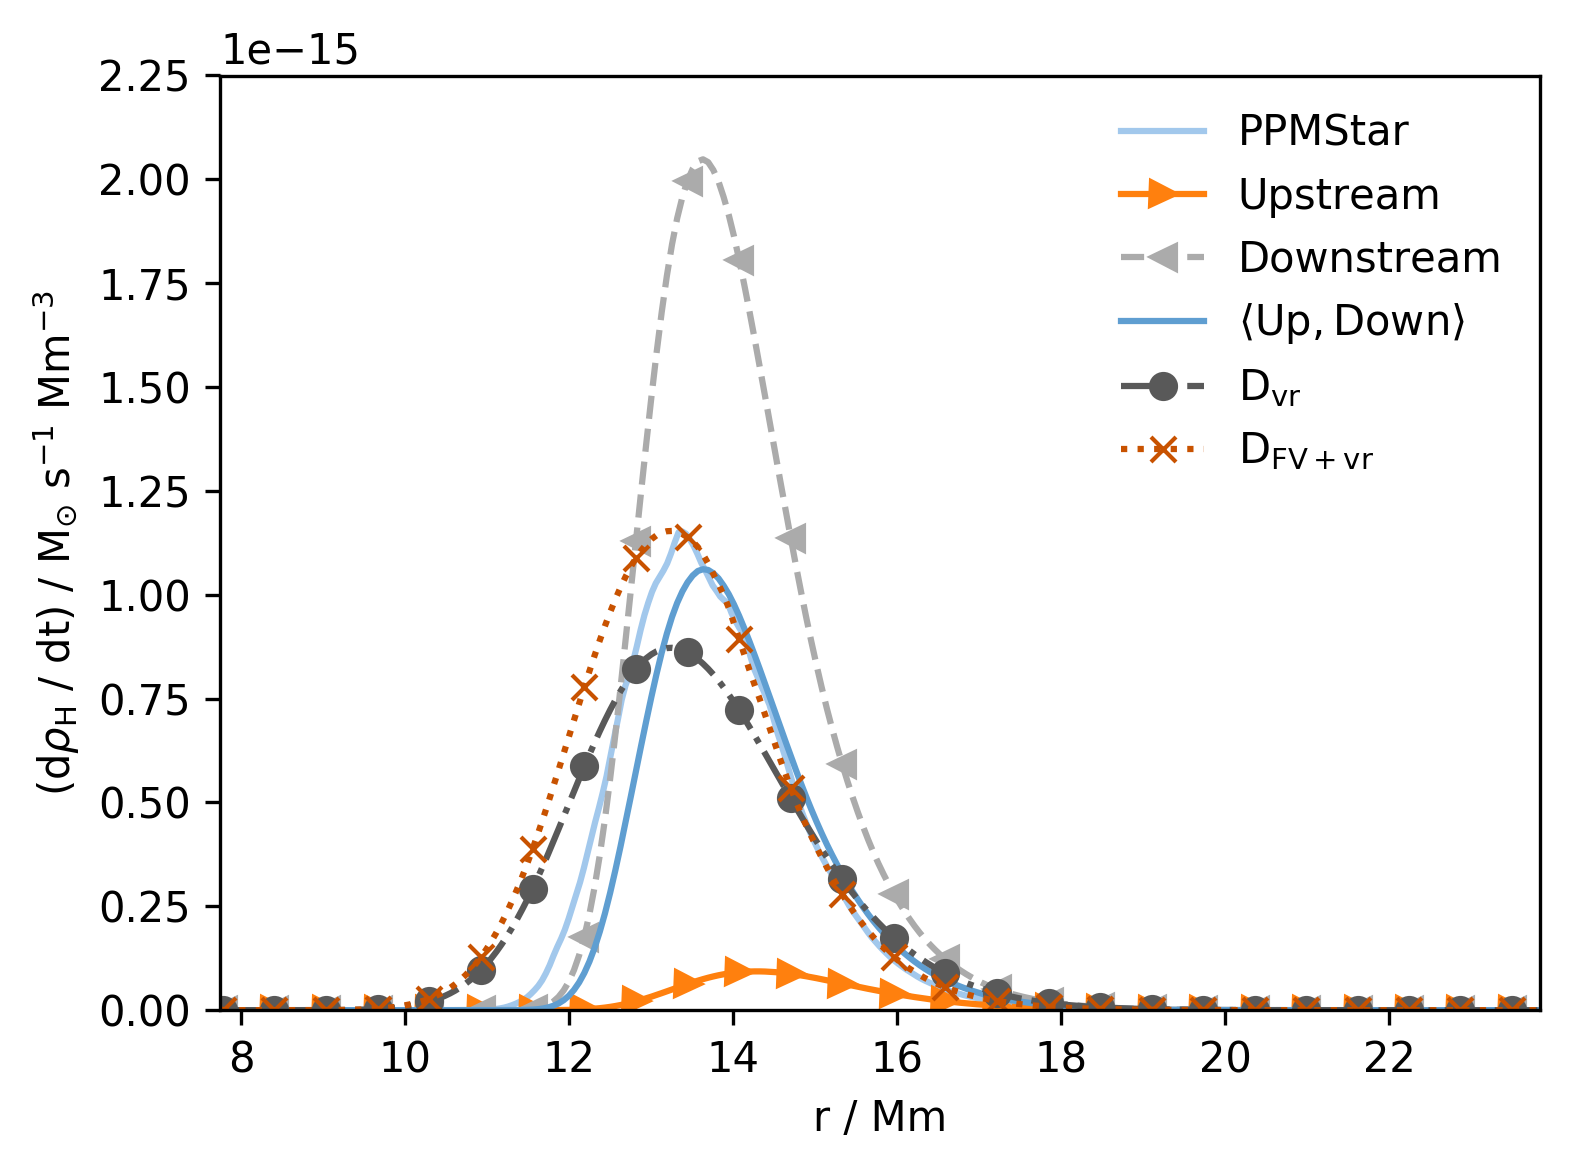

In [19]:
celln = 21

# loop through every run
for runstr, myrun in run.items():
    
    # are we working with every run?
    if runstr not in runs_plot:
        continue

    # celln
    celln += 1

    # configure plots
    close_local = ppm.close_plot(celln,ifig,ptrack)
    if close_local[0]:
        plt.close(fig); ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
        ppm.add_plot(celln,ifig,ptrack)
    else:
        ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
        ppm.add_plot(celln,ifig,ptrack)
    
    ax = fig.add_subplot(111)
    cbc = 0

    ax.plot(r_PPM[runstr],drhoHdt_PPM[runstr],ls=cb(0)[0],color=cb(0)[2],label='PPMStar')
  
    # mppnp 
    ax.plot(r_mppnp[runstr],drhoHdt_mppnp_up[runstr],ls=ls[0],color=color[0],
           label='Upstream',marker=marker[0],markevery=markevery[0])
    cbc += 1
    
    ax.plot(r_mppnp[runstr],drhoHdt_mppnp_down[runstr],ls=ls[1],color=color[1],
            label='Downstream',marker=marker[1],markevery=markevery[1])
    cbc += 1
    
    ax.plot(r_mppnp[runstr],drhoHdt_mppnp_ud_avg[runstr],ls=ls[2],color=color[2],
            label=r'$\langle \mathrm{Up},\mathrm{Down} \rangle$',marker=marker[2],markevery=markevery[2])
    cbc += 1

    ax.plot(r_mppnp[runstr],drhoHdt_mppnp_Dvr[runstr],ls=ls[3],color=color[3],
            label=r'D$_{\mathrm{vr}}$',marker=marker[3],markevery=markevery[3])
    cbc += 1

    ax.plot(r_mppnp[runstr],drhoHdt_mppnp_DFVvr[runstr],ls=ls[4],color=color[4],
            label=r'D$_{\mathrm{FV+vr}}$',marker=marker[4],markevery=markevery[4])
    cbc += 1
    
    # plot details
    ax.set_xlabel('r / Mm')
    ax.set_ylabel(r'(d$\rho_{\mathrm{H}}$ / dt) / M$_{\odot}$ s$^{-1}$ Mm$^{-3}$')
    ax.legend(frameon=False)
    rbot = m2r(myrun.mbot, myrun, myrun.dump0)
    rtop = m2r(myrun.mtop, myrun, myrun.dump0)
    ax.set_xlim([rbot, rtop])
    ax.set_ylim([0, 2.25e-15])
 
    # savefig
    fig.tight_layout()
    if save:
        fig.savefig(savefig[runstr],bbox_inches = "tight",dpi=300)
    if not render:
        plt.close()

What temperature does the reaction begin to burn hydrogen?

In [21]:
T9 = data['T9']
r = data['r']
T9_index = np.argmin(abs(r - 18))

print('The temperature at R={:0.1f} is T9={:0.3f}'.format(r[T9_index], T9[T9_index]))

The temperature at R=18.0 is T9=0.125


## HBurned

How much H was burned throughout the simulation in each of the hydro models. Compare with the advective mixing model and with just the entrainment rate linear fit!

In [22]:
# # taken from Hydro-Results.ipynb
# n16_entr_slope = 7.21e-12

In [23]:
# # dictionary that are run dependent
# Hburned_ud = collections.OrderedDict((run, []) for run in runs)
# Hburned_ud_avg = collections.OrderedDict((run, []) for run in runs)
# Hburned_Dvr = collections.OrderedDict((run, []) for run in runs)
# Hburned_DFVvr = collections.OrderedDict((run, []) for run in runs)
# Hburned_PPM = collections.OrderedDict((run, []) for run in runs)
# dumpStart = collections.OrderedDict((run, []) for run in runs)
# dumpEnd = collections.OrderedDict((run, []) for run in runs)

# # loop through the different runs
# for runstr, myrun in run.items():
    
#     # range of dumps to analyze
#     dumpStart[runstr] = myrun.simDump0
#     dumpEnd[runstr] = myrun.simDumpMax
    
#     # initialize zero arrays for Hburned
#     Hburned_ud[runstr] = np.zeros(dumpEnd[runstr] - dumpStart[runstr])
#     Hburned_ud_avg[runstr] = np.zeros(dumpEnd[runstr] - dumpStart[runstr])
#     Hburned_Dvr[runstr] = np.zeros(dumpEnd[runstr] - dumpStart[runstr])
#     Hburned_DFVvr[runstr] = np.zeros(dumpEnd[runstr] - dumpStart[runstr])
#     Hburned_PPM[runstr] = np.zeros(dumpEnd[runstr] - dumpStart[runstr])

In [24]:
# # temperature corrections are needed...
# T9corr_params = {'kind':1, 'params':{'a':0.46, 'b':0.77}}
# burn_args = {'T9corr_params':T9corr_params}

In [25]:
# # loop through the different runs
# for runstr, myrun in run.items():
        
#     # the dumps to loop over
#     dumps = list(range(dumpStart[runstr],dumpEnd[runstr]))
    
#     for counter, dump in enumerate(dumps):
        
#         # get dt over the time step
#         dt = np.diff(myrun.times)[dump]

#         # get the dmXhdt from PPMStar
#         r_PPM = myrun.rprof.get('R',fname=dump,resolution='l')                                         
#         dV = -4 * np.pi * r_PPM**2 * ppm.cdiff(r_PPM)

#         # try with the vc12pg equation I have
#         Tcorr = myrun.rprof.compute_T9corr(fname=dump, kind=T9corr_params['kind'],
#                                            params=T9corr_params['params'])
#         rho = myrun.rprof.get('Rho0',fname=dump,resolution='l') + myrun.rprof.get('Rho1',fname=dump,resolution='l')
#         Xcld = myrun.rprof.compute_Xcld(dump)
#         XH = Xcld * fkcld * atomicnoH / atomicnocld
#         XC12 = (1-Xcld) * fkair * atomicnoC12 / atomicnoair
#         drhoHdt_PPM = drhoH_dt(XH, XC12, rho, Tcorr, -dV)

#         # integrate space and time for PPMStar
#         if counter == 0:
#            Hburned_PPM[runstr][counter] = np.sum(drhoHdt_PPM * dV * dt)
#         else:
#            Hburned_PPM[runstr][counter] = np.sum(drhoHdt_PPM * dV * dt) + Hburned_PPM[runstr][counter-1]

#         # For mppnp use shell files for rho, T and r. Use se for mass fractions  
#         # I need to read in the structure for mppnp. It should be exactly the shell files
#         data, header = readSCFile(myrun.initbase, 'shell', dump)
#         rho_mppnp = shell2central(data['rho'])
#         T9_mppnp = data['T9'][0:-1]
#         r_mppnp = shell2central(data['r'])

#         dV_mppnp = 2. * np.pi * r_mppnp**2 * ppm.cdiff(r_mppnp)

#         XH_up = removelists(myrun.up_c12pg, 'H-1', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, dump, myrun.simDump0))
#         XH_down = removelists(myrun.down_c12pg, 'H-1', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, dump, myrun.simDump0))
#         XH_Dvr = removelists(myrun.Dvr_c12pg, 'H-1', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, dump, myrun.simDump0))
#         if runstr != 'n17':
#             XH_DFVvr = removelists(myrun.DFVvr_c12pg, 'H-1', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, dump, myrun.simDump0))

#         XC12_up = removelists(myrun.up_c12pg, 'C-12', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, dump, myrun.simDump0))
#         XC12_down = removelists(myrun.down_c12pg, 'C-12', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, dump, myrun.simDump0))
#         XC12_Dvr = removelists(myrun.Dvr_c12pg, 'C-12', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, dump, myrun.simDump0))
#         if runstr != 'n17':
#             XC12_DFVvr = removelists(myrun.DFVvr_c12pg, 'C-12', dump2cycle(myrun.nrepeatDump0, myrun.nsubt, dump, myrun.simDump0))

#         drhoHdt_mppnp_up = drhoH_dt(XH_up, XC12_up, rho_mppnp, T9_mppnp, dV_mppnp)
#         drhoHdt_mppnp_down = drhoH_dt(XH_down, XC12_down, rho_mppnp, T9_mppnp, dV_mppnp)
#         drhoHdt_mppnp_ud_avg = drhoH_dt((XH_down+XH_up)/2., (XC12_down +XC12_up)/2., rho_mppnp, T9_mppnp, 2*dV_mppnp)
#         drhoHdt_mppnp_Dvr = drhoH_dt(XH_Dvr, XC12_Dvr, rho_mppnp, T9_mppnp, 2*dV_mppnp)
#         if runstr != 'n17':
#             drhoHdt_mppnp_DFVvr = drhoH_dt(XH_DFVvr, XC12_DFVvr, rho_mppnp, T9_mppnp, 2*dV_mppnp)
#         else:
#             drhoHdt_mppnp_DFVvr = 0.

#         # integrate space and time for simulation (mppnp)
#         if counter == 0:
#            Hburned_ud[runstr][counter] = np.sum((drhoHdt_mppnp_up + drhoHdt_mppnp_down) * dV_mppnp * dt)
#            Hburned_ud_avg[runstr][counter] = np.sum((drhoHdt_mppnp_ud_avg) * 2 * dV_mppnp * dt)
#            Hburned_Dvr[runstr][counter] = np.sum(drhoHdt_mppnp_Dvr * 2 * dV_mppnp * dt)
#            Hburned_DFVvr[runstr][counter] = np.sum(drhoHdt_mppnp_DFVvr * 2 * dV_mppnp * dt)
#         else:
#            Hburned_ud[runstr][counter] = np.sum((drhoHdt_mppnp_up + drhoHdt_mppnp_down) * dV_mppnp * dt) + Hburned_ud[runstr][counter-1]
#            Hburned_ud_avg[runstr][counter] = np.sum((drhoHdt_mppnp_ud_avg) * 2 * dV_mppnp * dt) + Hburned_ud_avg[runstr][counter-1]
#            Hburned_Dvr[runstr][counter] = np.sum(drhoHdt_mppnp_Dvr * 2 * dV_mppnp * dt) + Hburned_Dvr[runstr][counter-1]
#            Hburned_DFVvr[runstr][counter] = np.sum(drhoHdt_mppnp_DFVvr * 2 * dV_mppnp * dt) + Hburned_DFVvr[runstr][counter-1]

#     # make burning equal to zero at the start
#     Hburned_PPM[runstr] -= Hburned_PPM[runstr][0]
#     Hburned_ud[runstr] -= Hburned_ud[runstr][0]
#     Hburned_ud_avg[runstr] -= Hburned_ud_avg[runstr][0]    
#     Hburned_Dvr[runstr] -= Hburned_Dvr[runstr][0]
#     Hburned_DFVvr[runstr] -= Hburned_DFVvr[runstr][0]
    
#     # make Hburned in solar mass
#     Hburned_PPM[runstr] *= 1e27/ast.msun_g
#     Hburned_ud[runstr] *= 1e27/ast.msun_g
#     Hburned_ud_avg[runstr] *= 1e27/ast.msun_g
#     Hburned_Dvr[runstr] *= 1e27/ast.msun_g
#     Hburned_DFVvr[runstr] *= 1e27/ast.msun_g

Plot dependent dictionaries

In [26]:
# # if i want to look at one particular run and/or radii
# runs_plot = ['n16', 'n17']

# # plot stuff
# savefig = 'Hburned.pdf'
# render = True
# save = False
# thickline = collections.OrderedDict(zip(run.keys(), [1, 2]))

In [27]:
# celln = 19

# # configure plots
# close_local = ppm.close_plot(celln,ifig,ptrack)
# if close_local[0]:
#     plt.close(fig); ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
#     ppm.add_plot(celln,ifig,ptrack)
# else:
#     ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
#     ppm.add_plot(celln,ifig,ptrack)

# ax = fig.add_subplot(111)

# # loop through every run
# for runstr, myrun in run.items():
    
#     # are we working with every run?
#     if runstr not in runs_plot:
#         continue
    
#     cbc = 0
    
#     # plot the total burned
#     if runstr != 'n16':
        
#         # PPM
#         ax.plot((myrun.times - myrun.times[myrun.simDump0])[myrun.simDump0:myrun.simDumpMax] / 60.,
#                 Hburned_PPM[runstr],ls=cb(cbc)[0],color=cb(cbc)[2],linewidth=thickline[runstr])
#         cbc += 1
        
#         # ud
#         ax.plot((myrun.times - myrun.times[myrun.simDump0])[myrun.simDump0:myrun.simDumpMax] / 60.,
#                 Hburned_ud[runstr],ls=cb(cbc)[0],color=cb(cbc)[2],linewidth=thickline[runstr])
#         cbc += 1
        
#         # Jones
#         ax.plot((myrun.times - myrun.times[myrun.simDump0])[myrun.simDump0:myrun.simDumpMax] / 60.,
#                 Hburned_Dvr[runstr],ls=cb(cbc)[0],color=cb(cbc)[2],linewidth=thickline[runstr])
#         cbc += 1  
        
#         # DFV+vr
#         ax.plot((myrun.times - myrun.times[myrun.simDump0])[myrun.simDump0:myrun.simDumpMax] / 60.,
#                 Hburned_DFVvr[runstr],ls=cb(cbc)[0],color=cb(cbc)[2],linewidth=thickline[runstr])
#         cbc += 1    
        
#     else:
#         # PPM
#         ax.plot((myrun.times - myrun.times[myrun.simDump0])[myrun.simDump0:myrun.simDumpMax] / 60.,
#                 Hburned_PPM[runstr],ls=cb(cbc)[0],color=cb(cbc)[2],label='PPMStar',linewidth=thickline[runstr])
#         cbc += 1
        
#         # ud
#         ax.plot((myrun.times - myrun.times[myrun.simDump0])[myrun.simDump0:myrun.simDumpMax] / 60.,
#                 Hburned_ud[runstr],ls=cb(cbc)[0],color=cb(cbc)[2],label='Advection',linewidth=thickline[runstr])
#         cbc += 1

#         # Jones
#         ax.plot((myrun.times - myrun.times[myrun.simDump0])[myrun.simDump0:myrun.simDumpMax] / 60.,
#                 Hburned_Dvr[runstr],ls=cb(cbc)[0],color=cb(cbc)[2],label=r'D$_{\mathrm{vr}}$',linewidth=thickline[runstr])
#         cbc += 1  
        
#         # DFV+vr
#         ax.plot((myrun.times - myrun.times[myrun.simDump0])[myrun.simDump0:myrun.simDumpMax] / 60.,
#                 Hburned_DFVvr[runstr],ls=cb(cbc)[0],color=cb(cbc)[2],label=r'D$_{\mathrm{FV+vr}}$',linewidth=thickline[runstr])
#         cbc += 1     
        
# # plot details
# ax.set_xlabel('t / min')
# ax.set_ylabel(r'Mass of H Burned / M$_{\odot}$')
# xlims = ax.get_xlim()
# ylims = ax.get_ylim()
# ax.set_xlim([0,xlims[-1]])
# ax.set_ylim([1e-8,ylims[-1]])
# ax.set_yscale('log')
# # ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.legend(frameon=False)

# # savefig
# fig.tight_layout()
# fig.savefig(savefig,bbox_inches = "tight",dpi=300)
# if not render:
#     plt.close()

## C12pg Only

Note that this uses the previous sections variable "run_dump". These profiles MUST be the same as the rates for a useful comparison in the paper

In [28]:
# dictionary that are run dependent
XHrprof = collections.OrderedDict((run, []) for run in runs)
XHmppnpU = collections.OrderedDict((run, []) for run in runs)
XHmppnpD = collections.OrderedDict((run, []) for run in runs)
XHmppnpAvg = collections.OrderedDict((run, []) for run in runs)
XHmppnpDvr = collections.OrderedDict((run, []) for run in runs)
XHmppnpDFVvr = collections.OrderedDict((run, []) for run in runs)
rrprof = collections.OrderedDict((run, []) for run in runs)
rmppnp = collections.OrderedDict((run, []) for run in runs)

In [29]:
# loop through the different runs
for runstr, myrun in run.items():

    # get the rprof "rprof"
    rrprof[runstr] = myrun.rprof.get('R',fname=run_dump[runstr],resolution='l')
    X_rprof = myrun.rprof.compute_Xcld(fname=run_dump[runstr])
    XHrprof[runstr] = X_rprof * fkcld * (atomicnoH / atomicnocld)
    
    # mppnp, use shell files for radii
    data, header = readSCFile(myrun.initbase, 'shell', run_dump[runstr])
    rmppnp[runstr] = shell2central(data['r'])

    XHmppnpU[runstr] = removelists(myrun.up_c12pg, 'H-1', 
                                   dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
    XHmppnpD[runstr] = removelists(myrun.down_c12pg, 'H-1', 
                                   dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
    XHmppnpAvg[runstr] = (XHmppnpU[runstr] + XHmppnpD[runstr]) / 2.
    XHmppnpDvr[runstr] = removelists(myrun.Dvr_c12pg, 'H-1', 
                                     dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
    if runstr != 'n17':
        XHmppnpDFVvr[runstr] = removelists(myrun.DFVvr_c12pg, 'H-1', 
                                           dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))

 reading ['iso_massf']...100%

#### Advection C12pg Plot

In [30]:
# if i want to look at one particular run and/or radii
runs_plot = ['n16', 'n17']

# plot stuff
savefig = collections.OrderedDict((run, []) for run in runs)

for runstr, myrun in run.items():
    savefig[runstr] = '{:s}-adv-c12pg-XHrprofs.pdf'.format(runstr.capitalize())
    
render = True
save = True

# run dependent quantities
XHmin = collections.OrderedDict(zip(run.keys(), [1e-8, 1e-8]))
XHmax = collections.OrderedDict(zip(run.keys(), [1e-3, 1e-2]))
entr_offset = collections.OrderedDict(zip(run.keys(), [0.5, 5.0]))

# for any run, plot quantity dependencies
ls = ['-', '--', '-.']
color = [cb(1)[2], cb(2)[2], cb(3)[2]]
marker = ['>', '<', None]
markevery = [30, 30, 30]

## Fig 14

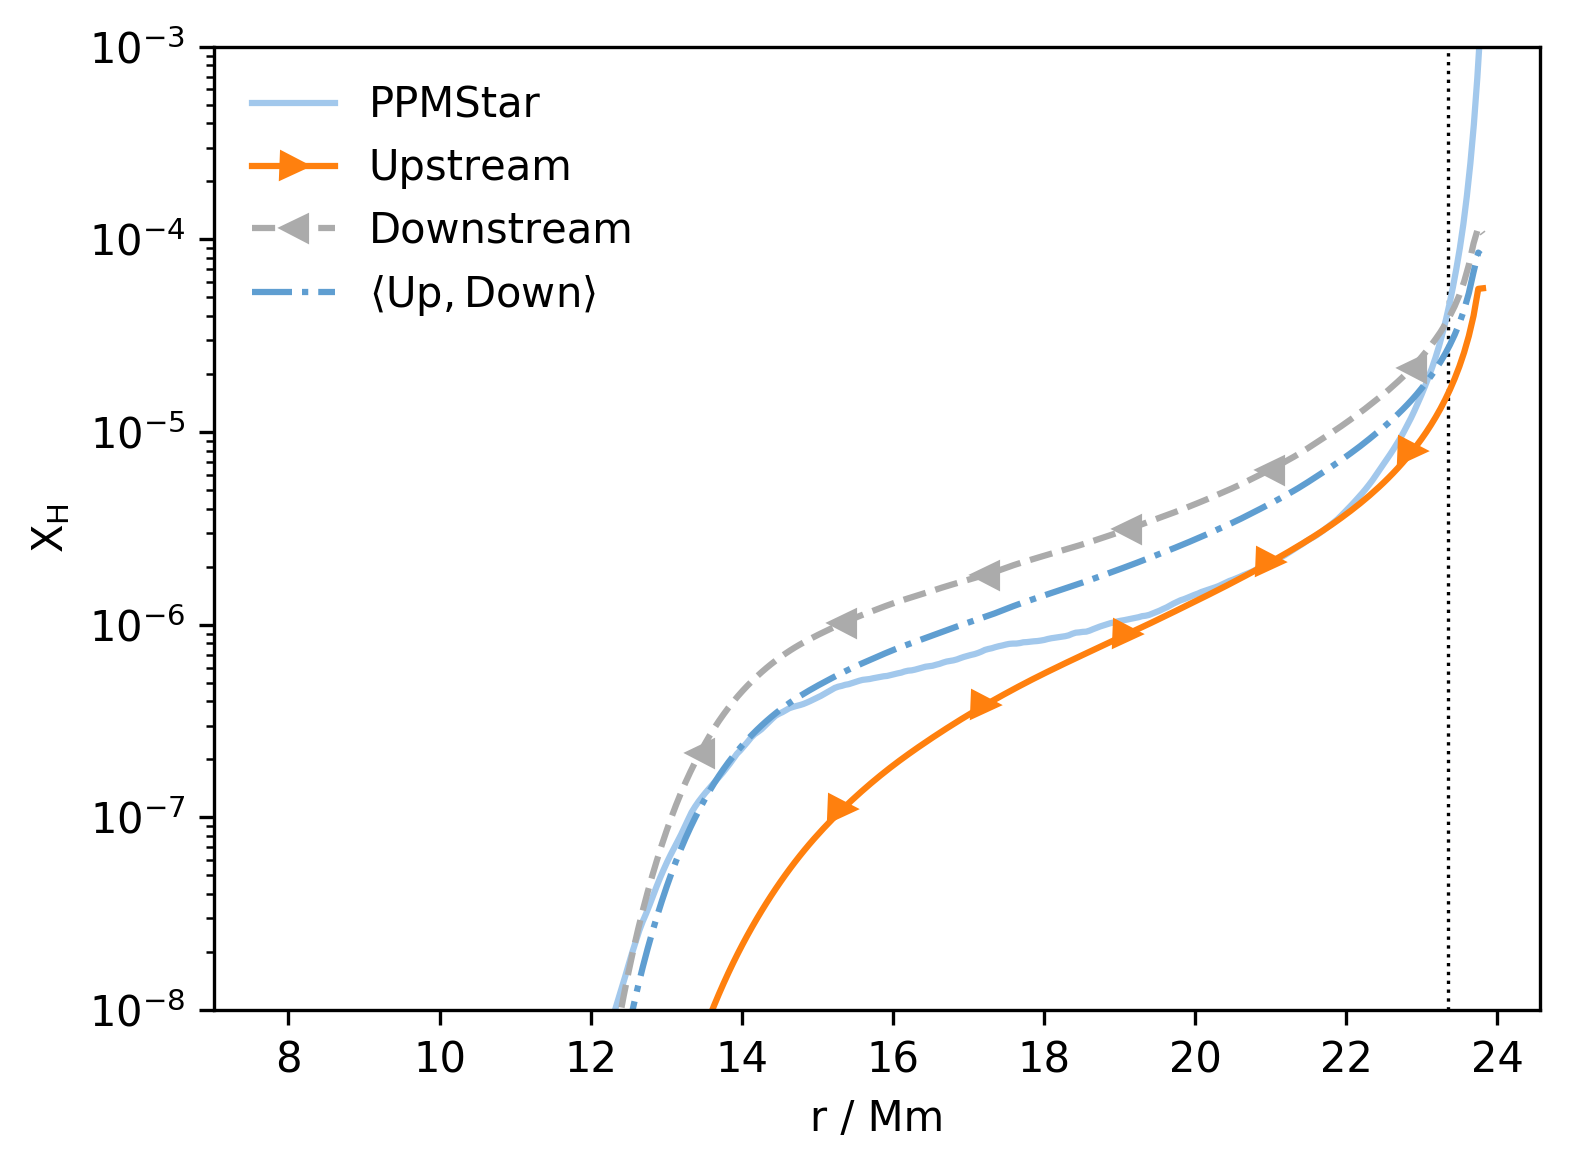

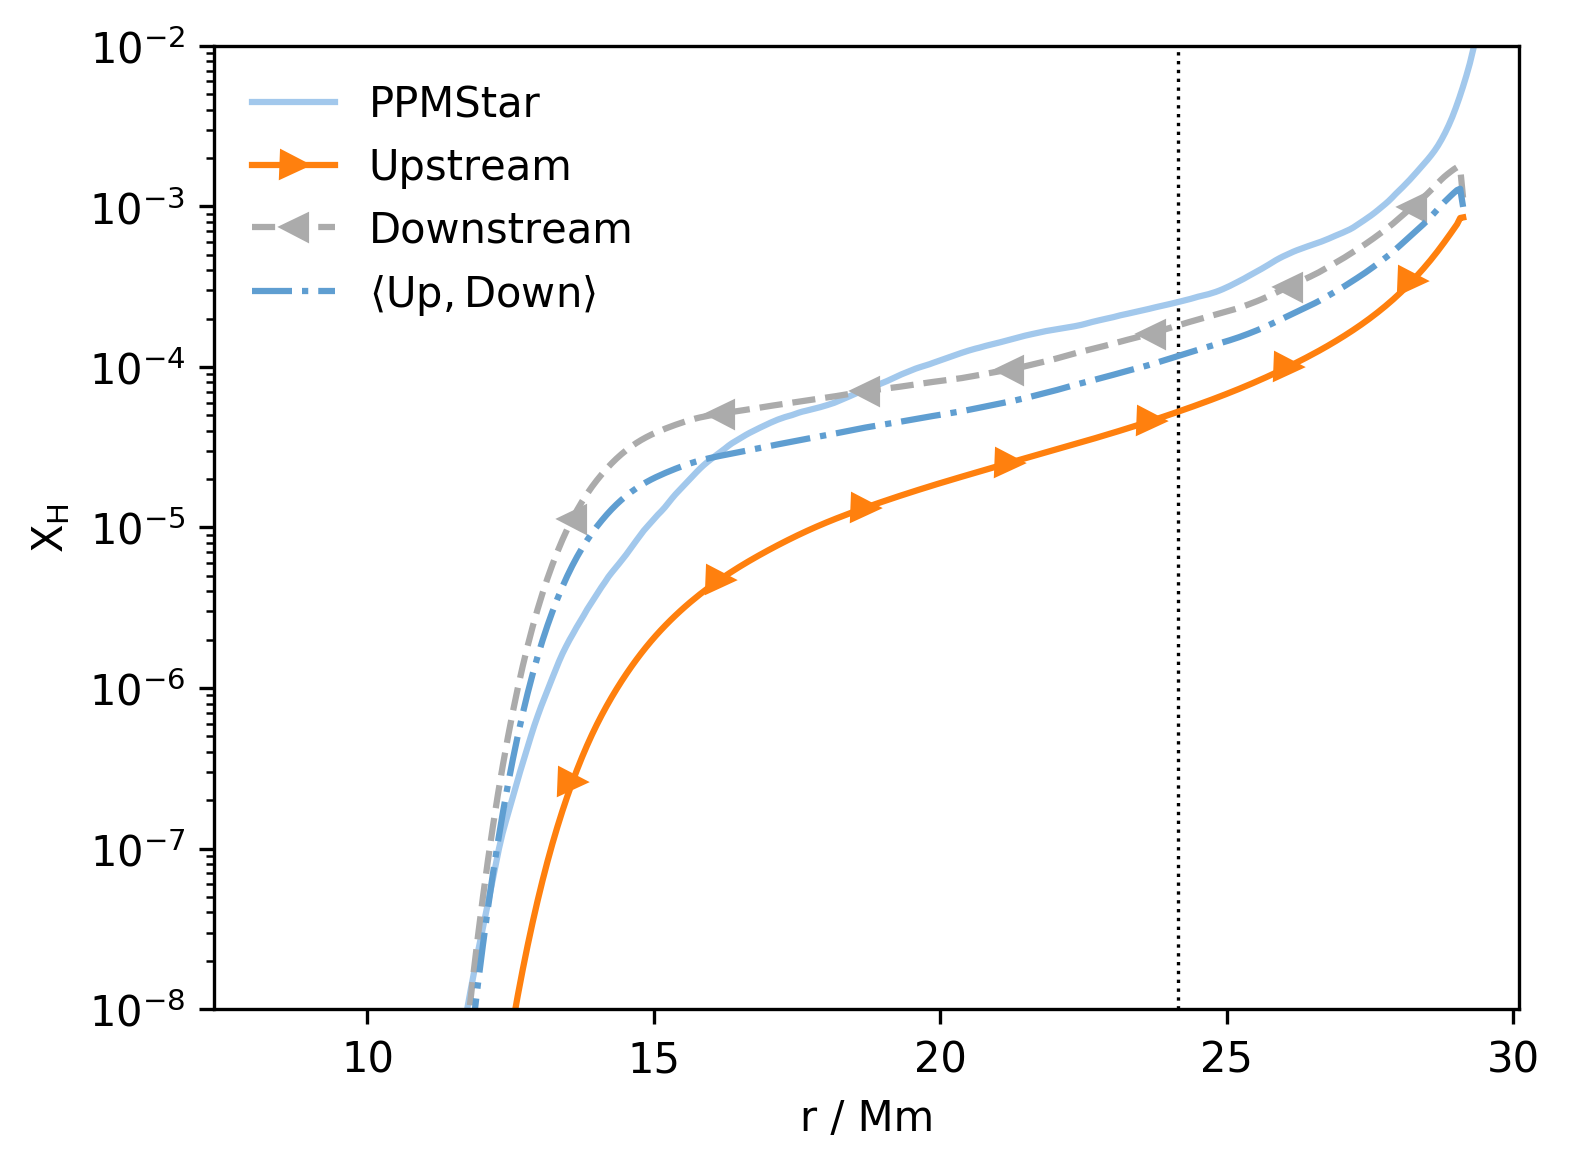

In [31]:
celln = 23

# loop through every run
for runstr, myrun in run.items():
    
    # are we working with every run?
    if runstr not in runs_plot:
        continue

    # celln
    celln += 1

    # configure plots
    close_local = ppm.close_plot(celln,ifig,ptrack)
    if close_local[0]:
        plt.close(fig); ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
        ppm.add_plot(celln,ifig,ptrack)
    else:
        ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
        ppm.add_plot(celln,ifig,ptrack)

    ax = fig.add_subplot(111)
    cbc = 0

    # rprof boundaries
    XHrange = [XHmin[runstr],XHmax[runstr]]
    rRange = [rmppnp[runstr].min() - 12*np.abs(np.diff(rmppnp[runstr]).mean()),
              rmppnp[runstr].max() + 12*np.abs(np.diff(rmppnp[runstr]).mean())]

    # add a vertical line for the entrainment rate measurement
    xline = m2r(myrun.mtop, myrun, run_dump[runstr]) - entr_offset[runstr]
    ax.vlines(xline, *XHrange, color='k', linestyle=':',linewidth=0.8)

    # PPMstar
    ax.plot(rrprof[runstr], XHrprof[runstr], label='PPMStar', ls=cb(0)[0], color=cb(0)[2])

    # mppnp
    ax.plot(rmppnp[runstr], XHmppnpU[runstr], label='Upstream', ls=ls[0], color=color[0], 
           marker=marker[0], markevery=markevery[0])

    ax.plot(rmppnp[runstr], XHmppnpD[runstr], label='Downstream', ls=ls[1], color=color[1], 
           marker=marker[1], markevery=markevery[1])    

    ax.plot(rmppnp[runstr],XHmppnpAvg[runstr], label=r'$\langle \mathrm{Up},\mathrm{Down} \rangle$', 
            ls=ls[2], color=color[2], marker=marker[2], markevery=markevery[2])    

    # ax2 properties
    ax.set_xlabel('r / Mm')
    ax.set_ylabel('X$_{\mathrm{H}}$')
    ax.set_yscale('log')
    ax.set_ylim(XHrange)
    ax.set_xlim(rRange)
    ax.legend(frameon=False, loc='upper left')

    # savefig
    fig.tight_layout()
    if save:
        fig.savefig(savefig[runstr],bbox_inches = "tight",dpi=300)
    if not render:
        plt.close()

#### Diffusion C12pg Plot

In [32]:
# if i want to look at one particular run and/or radii
runs_plot = ['n16']

# plot stuff
savefig = collections.OrderedDict((run, []) for run in runs)

for runstr, myrun in run.items():
    savefig[runstr] = '{:s}-diff-c12pg-XHrprofs.pdf'.format(runstr.capitalize())
    
render = True
save = True

# run dependent quantities
XHmin = collections.OrderedDict(zip(run.keys(), [1e-8, 1e-8]))
XHmax = collections.OrderedDict(zip(run.keys(), [1e-3, 1e-2]))
entr_offset = collections.OrderedDict(zip(run.keys(), [0.5, 5.0]))

# for any run, plot quantity dependencies
ls = ['-.', ':']
color = [cb(1)[2], cb(2)[2]]
marker = ['o', 'x']
markevery = [30, 30]

## Fig 13

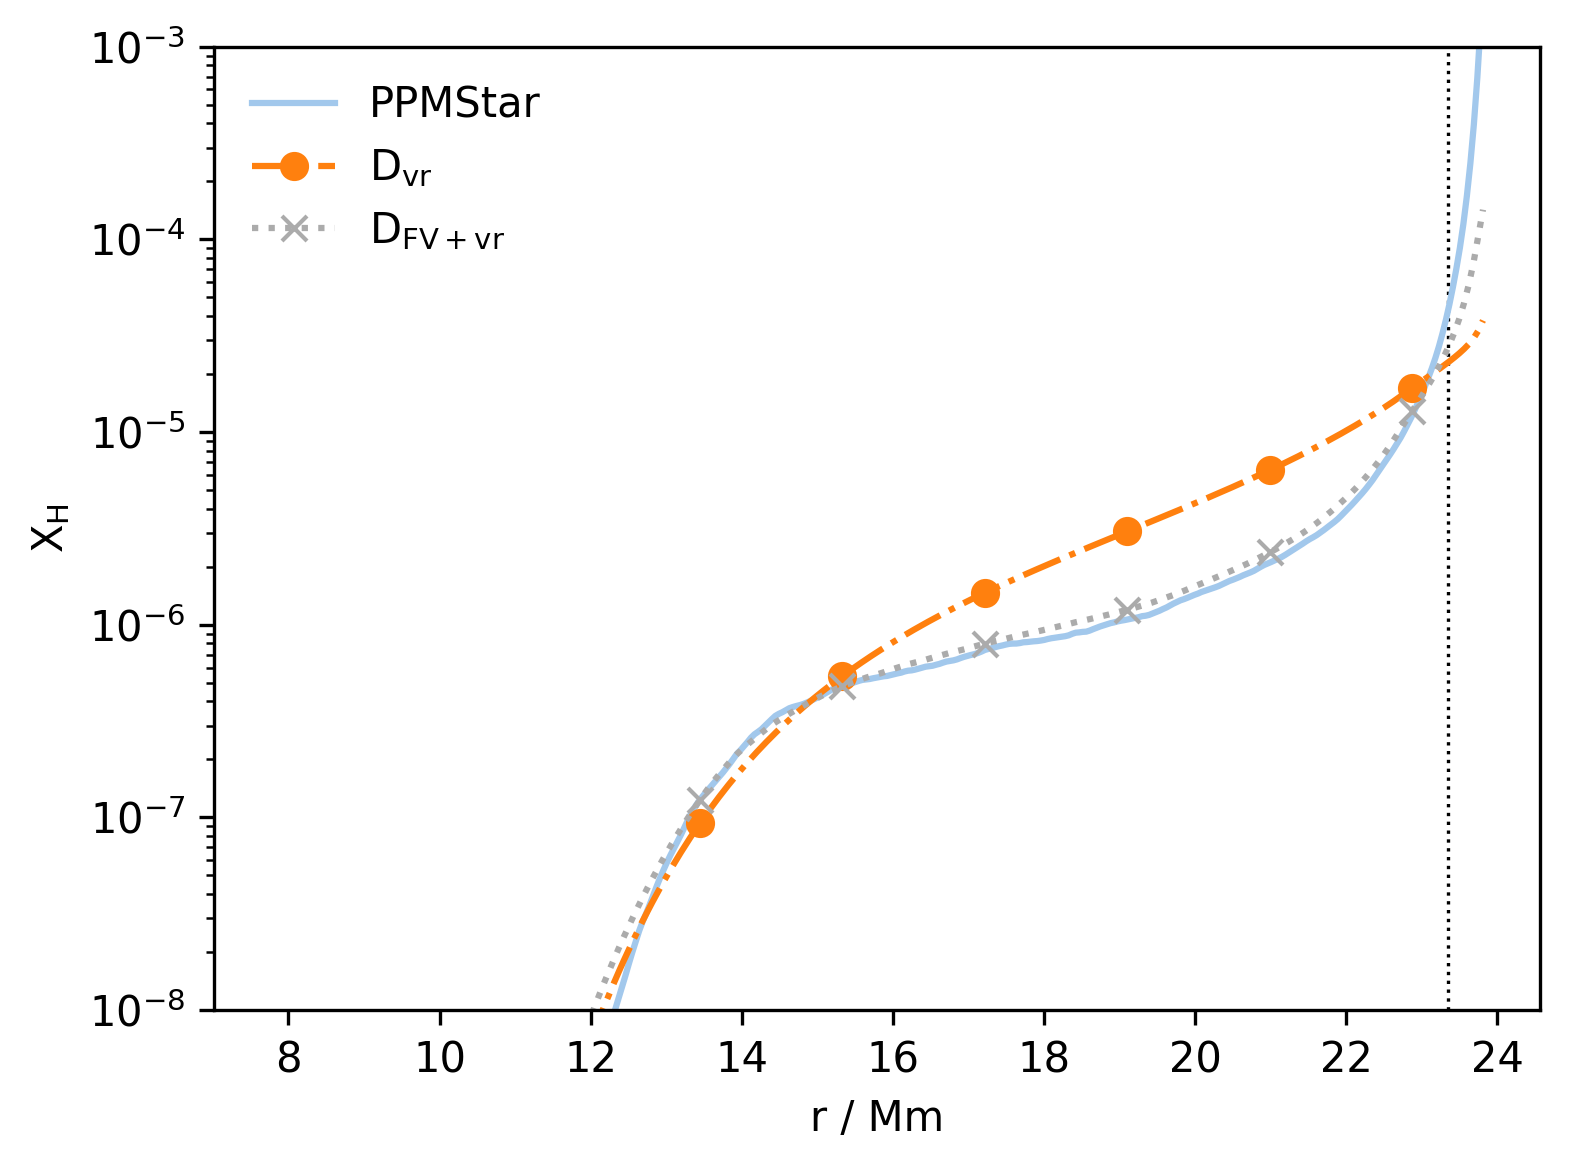

In [33]:
celln = 25

# loop through every run
for runstr, myrun in run.items():
    
    # are we working with every run?
    if runstr not in runs_plot:
        continue

    # celln
    celln += 1

    # configure plots
    close_local = ppm.close_plot(celln,ifig,ptrack)
    if close_local[0]:
        plt.close(fig); ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
        ppm.add_plot(celln,ifig,ptrack)
    else:
        ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
        ppm.add_plot(celln,ifig,ptrack)

    ax = fig.add_subplot(111)
    cbc = 0

    # rprof boundaries
    XHrange = [XHmin[runstr],XHmax[runstr]]
    rRange = [rmppnp[runstr].min() - 12*np.abs(np.diff(rmppnp[runstr]).mean()),
              rmppnp[runstr].max() + 12*np.abs(np.diff(rmppnp[runstr]).mean())]

    # add a vertical line for the entrainment rate measurement
    xline = m2r(myrun.mtop, myrun, run_dump[runstr]) - entr_offset[runstr]
    ax.vlines(xline, *XHrange, color='k', linestyle=':',linewidth=0.8)

    # PPMstar
    ax.plot(rrprof[runstr], XHrprof[runstr], label='PPMStar', ls=cb(0)[0], color=cb(0)[2])

    # mppnp
    ax.plot(rmppnp[runstr], XHmppnpDvr[runstr], label=r'D$_{\mathrm{vr}}$', ls=ls[0], color=color[0], 
           marker=marker[0], markevery=markevery[0])

    ax.plot(rmppnp[runstr], XHmppnpDFVvr[runstr], label=r'D$_{\mathrm{FV+vr}}$', ls=ls[1], color=color[1], 
           marker=marker[1], markevery=markevery[1])    

    # ax2 properties
    ax.set_xlabel('r / Mm')
    ax.set_ylabel('X$_{\mathrm{H}}$')
    ax.set_yscale('log')
    ax.set_ylim(XHrange)
    ax.set_xlim(rRange)
    ax.legend(frameon=False, loc='upper left')

    # savefig
    fig.tight_layout()
    if save:
        fig.savefig(savefig[runstr],bbox_inches = "tight",dpi=300)
    if not render:
        plt.close()

## Full Network

In [34]:
# for different plots at different times
run_calc = ['n16', 'n17']

# in case we want PPMStar
XHrprof = collections.OrderedDict((run, []) for run in runs)

# for different species
species = ['H-1', 'N-13', 'C-13', 'Kr-88', 'Kr-89', 'Kr-90']

# dictionary that are run and time dependent
XmppnpU = collections.OrderedDict((run, 
                                collections.OrderedDict(zip(species, 
                                                            [1]*len(species)))) for run in runs)
XmppnpD = collections.OrderedDict((run, 
                                collections.OrderedDict(zip(species, 
                                                            [1]*len(species)))) for run in runs)
XmppnpDFVvr = collections.OrderedDict((run, 
                                collections.OrderedDict(zip(species, 
                                                            [1]*len(species)))) for run in runs)
XmppnpDvr = collections.OrderedDict((run, 
                                collections.OrderedDict(zip(species, 
                                                            [1]*len(species)))) for run in runs)

rrprof = collections.OrderedDict((run, []) for run in runs)
rmppnp = collections.OrderedDict((run, []) for run in runs)

In [35]:
# loop through the different runs
for runstr, myrun in run.items():

    # do we even have the data?
    if runstr not in run_calc:
        continue
    
    # get the rprof "rprof"
    rrprof[runstr] = myrun.rprof.get('R',fname=run_dump[runstr],resolution='l')
    X_rprof = myrun.rprof.compute_Xcld(fname=run_dump[runstr])
    XHrprof[runstr] = X_rprof * fkcld * (atomicnoH / atomicnocld)
    
    # mppnp, use shell files for radii
    data, header = readSCFile(myrun.initbase, 'shell', run_dump[runstr])
    rmppnp[runstr] = shell2central(data['r'])

In [36]:
    
    # now for every species
    for specie in species:

        XmppnpU[runstr][specie] = removelists(myrun.up_fnet, specie, 
                                       dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
        XmppnpD[runstr][specie] = removelists(myrun.down_fnet, specie, 
                                       dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
        XmppnpDvr[runstr][specie] = removelists(myrun.Dvr_fnet, specie, 
                                         dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))
        if runstr != 'n17':
            XmppnpDFVvr[runstr][specie] = removelists(myrun.DFVvr_fnet, specie, 
                                               dump2cycle(myrun.nrepeatDump0, myrun.nsubt, run_dump[runstr], myrun.simDump0))

IndexError: list index out of range

#### Advection and Diffusion H,N13,C13 Plot

In [ ]:
# if i want to look at one particular run and/or radii
runs_plot = ['n16', 'n17']

# plot stuff
savefig = collections.OrderedDict((run, []) for run in runs)

for runstr, myrun in run.items():
    savefig[runstr] = '{:s}-HN13C13-fnet.pdf'.format(runstr.capitalize())
    
render = True
save = True

# run dependent quantities
Xmin = collections.OrderedDict(zip(run.keys(), [2e-11, 1e-8]))
Xmax = collections.OrderedDict(zip(run.keys(), [2e-4, 1e-2]))

# for any run, plot quantity dependencies
plot_species = ['H-1', 'N-13', 'C-13']
species_latex = [r'H', r'$\mathrm{^{13}N}$', r'$\mathrm{^{13}C}$']
species_labels = collections.OrderedDict(zip(plot_species, species_latex))
ls = ['-', '--', '-.', ':']
color = [cb(1)[2], cb(2)[2], cb(5)[2]]
marker = ['>', '<', 'o', 'x']
markevery = [30]*len(marker)
markersize = [4]*len(markevery)

In [ ]:
celln = 29

# loop through every run
for runstr, myrun in run.items():
    
    # are we working with every run?
    if runstr not in runs_plot:
        continue

    # celln
    celln += 1

    # configure plots
    close_local = ppm.close_plot(celln,ifig,ptrack)
    if close_local[0]:
        plt.close(fig); ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
        ppm.add_plot(celln,ifig,ptrack)
    else:
        ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
        ppm.add_plot(celln,ifig,ptrack)

    ax = fig.add_subplot(111)
    cbc = 0

    # rprof boundaries
    Xrange = [Xmin[runstr],Xmax[runstr]]
    rRange = [rmppnp[runstr].min() - 12*np.abs(np.diff(rmppnp[runstr]).mean()),
              rmppnp[runstr].max() + 12*np.abs(np.diff(rmppnp[runstr]).mean())]

    # mppnp, for the species in the plot_species
    for i,specie in enumerate(plot_species):
        
        if specie == 'H-1':
            ax.plot(rrprof[runstr], XHrprof[runstr], label='PPMStar H', ls=cb(0)[0], color=cb(0)[2])
            
        ax.plot(rmppnp[runstr], XmppnpU[runstr][specie], label=species_labels[specie], ls=ls[0], 
                color=color[i], marker=marker[0], markevery=markevery[0], markersize=markersize[0])
        ax.plot(rmppnp[runstr], XmppnpD[runstr][specie], ls=ls[1], color=color[i], 
               marker=marker[1], markevery=markevery[1], markersize=markersize[1])
        ax.plot(rmppnp[runstr], XmppnpDvr[runstr][specie], ls=ls[2], color=color[i], 
               marker=marker[2], markevery=markevery[2], markersize=markersize[2])
        if runstr != 'n17':
            ax.plot(rmppnp[runstr], XmppnpDFVvr[runstr][specie], ls=ls[3], color=color[i], 
                   marker=marker[3], markevery=markevery[3], markersize=markersize[3])

    # ax2 properties
    ax.set_xlabel('r / Mm')
    ax.set_ylabel('X')
    ax.set_yscale('log')
    ax.set_ylim(Xrange)
    ax.set_xlim(rRange)
    ax.legend(frameon=False, loc='lower right')

    # savefig
    fig.tight_layout()
    if save:
        fig.savefig(savefig[runstr],bbox_inches = "tight",dpi=300)
    if not render:
        plt.close()

#### Advection and Diffusion Kr Isotopes

In [ ]:
# if i want to look at one particular run and/or radii
runs_plot = ['n16', 'n17']

# plot stuff
savefig = collections.OrderedDict((run, []) for run in runs)

for runstr, myrun in run.items():
    savefig[runstr] = '{:s}-Kr-isotopes-fnet.pdf'.format(runstr.capitalize())
    
render = True
save = True

# run dependent quantities
Xmin = collections.OrderedDict(zip(run.keys(), [1e-20, 1e-16]))
Xmax = collections.OrderedDict(zip(run.keys(), [1e-10, 1e-9]))

# for any run, plot quantity dependencies
plot_species = ['Kr-88', 'Kr-89','Kr-90']
species_latex = [r'$\mathrm{^{88}Kr}$', r'$\mathrm{^{89}Kr}$', r'$\mathrm{^{90}Kr}$']
species_labels = collections.OrderedDict(zip(plot_species, species_latex))
ls = ['-', '--', '-.', ':']
color = [cb(4)[2], cb(6)[2], cb(8)[2], cb(6)[2], cb(7)[2]]
marker = ['>', '<', 'o', 'x']
markevery = [30]*len(marker)
markersize = [4]*len(markevery)

NameError: name 'Xmin' is not defined

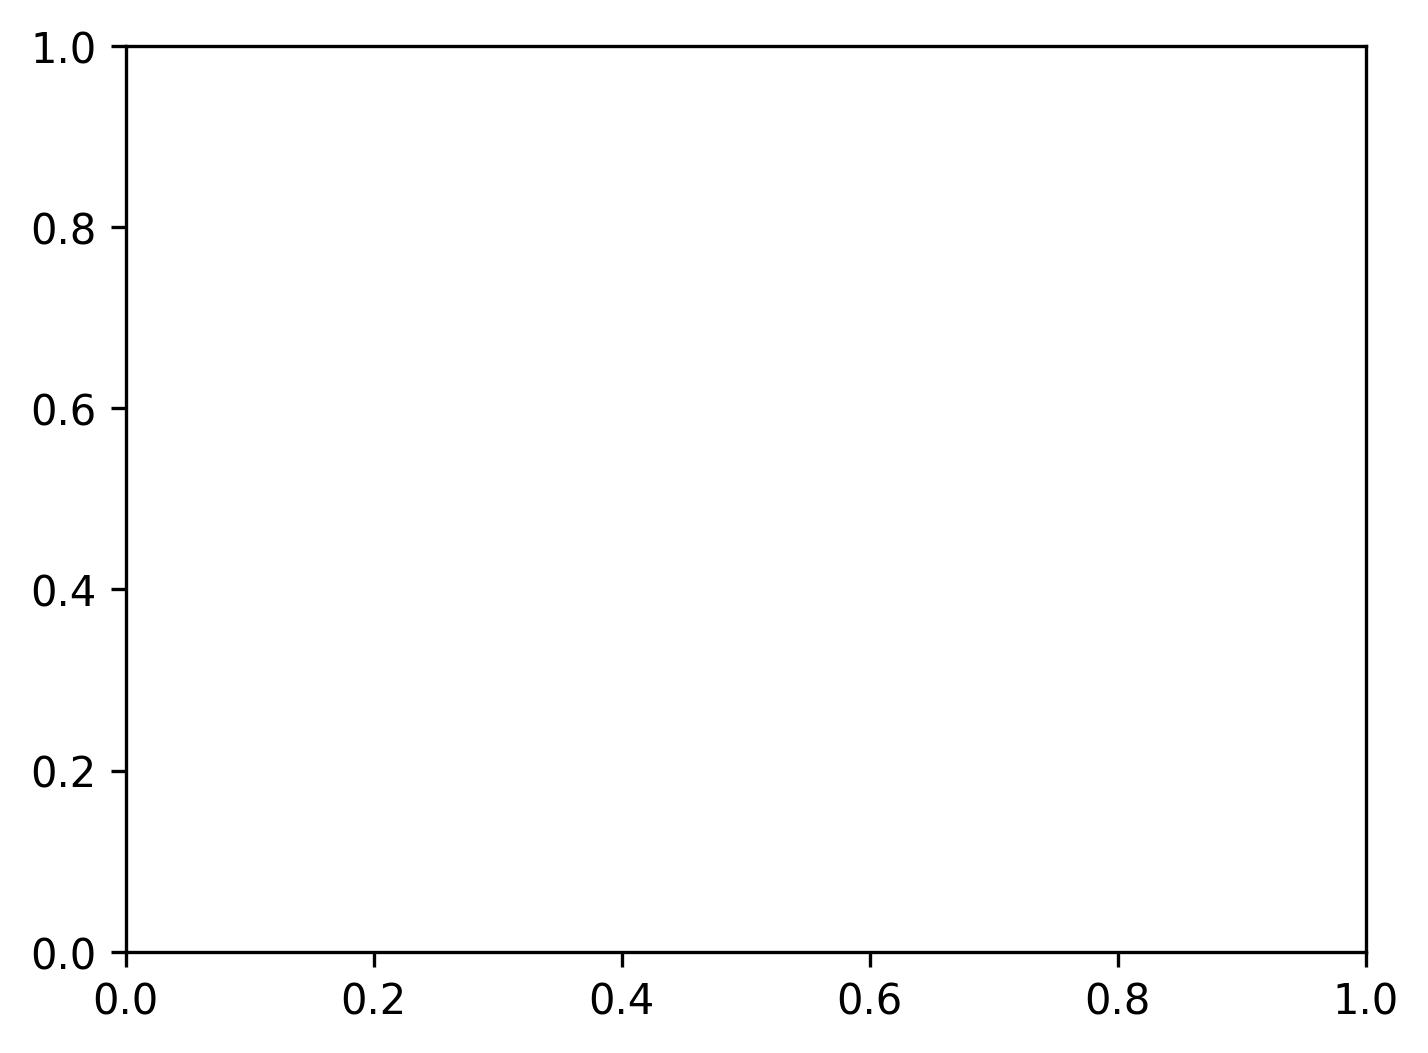

In [39]:
celln = 34

# loop through every run
for runstr, myrun in run.items():
    
    # are we working with every run?
    if runstr not in runs_plot:
        continue

    # celln
    celln += 1

    # configure plots
    close_local = ppm.close_plot(celln,ifig,ptrack)
    if close_local[0]:
        plt.close(fig); ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
        ppm.add_plot(celln,ifig,ptrack)
    else:
        ifig += 1; fig = plt.figure(ifig,figsize=(stdRatio*stdSize,stdSize),dpi=300)
        ppm.add_plot(celln,ifig,ptrack)

    ax = fig.add_subplot(111)
    cbc = 0

    # rprof boundaries
    Xrange = [Xmin[runstr],Xmax[runstr]]
    rRange = [rmppnp[runstr].min() - 12*np.abs(np.diff(rmppnp[runstr]).mean()),
              rmppnp[runstr].max() + 12*np.abs(np.diff(rmppnp[runstr]).mean())]

    # mppnp, for the species in the plot_species
    for i,specie in enumerate(plot_species):

        ax.plot(rmppnp[runstr], XmppnpU[runstr][specie], label=species_labels[specie], ls=ls[0], 
                color=color[i], marker=marker[0], markevery=markevery[0], markersize=markersize[0])
        ax.plot(rmppnp[runstr], XmppnpD[runstr][specie], ls=ls[1], color=color[i], 
               marker=marker[1], markevery=markevery[1], markersize=markersize[1])
        ax.plot(rmppnp[runstr], XmppnpDvr[runstr][specie], ls=ls[2], color=color[i], 
               marker=marker[2], markevery=markevery[2], markersize=markersize[2])
        if runstr != 'n17':
            ax.plot(rmppnp[runstr], XmppnpDFVvr[runstr][specie], ls=ls[3], color=color[i], 
                   marker=marker[3], markevery=markevery[3], markersize=markersize[3])

    # ax2 properties
    ax.set_xlabel('r / Mm')
    ax.set_ylabel('X')
    ax.set_yscale('log')
    ax.set_ylim(Xrange)
    ax.set_xlim(rRange)
    ax.legend(frameon=False, loc='best')

    # savefig
    fig.tight_layout()
    if save:
        fig.savefig(savefig[runstr],bbox_inches = "tight",dpi=300)
    if not render:
        plt.close()